# Tracing pluripotency of human early embryos and embryonic stem cells by single cell RNA-seq

*Public on Aug 10, 2013*

**Homo sapiens**: Expression profiling by high throughput sequencing

*Find the casual relationship between gene expression network and cellular phenotype at single cell resolution. We collected donated human pre-implatation embryos, and the embryonic stem cells derived from them, isolate individual cells, prepared single cell cDNAs, and sequenced them by HiSeq2000. Then we analyzed the expression of known RefSeq genes.*
 	
Overall design	We get transcriptome of 124 individual cells from human pre-implantation embryos and human embryonic stem cells by applying single cell RNA-seq technique we recently developed[1][2][3][4]. We did in-depth bioinformatic analysis to these data and found very dynamic expression of protein-coding genes.
[1] Tang, F. et al. (2010a) Tracing the Derivation of Embryonic Stem Cells from the Inner Cell Mass by Single-Cell RNA-Seq Analysis. Cell Stem Cell 6, 468-478.
[2] Tang, F. et al. (2010b) RNA-Seq analysis to capture the transcriptome landscape of a single cell. Nat Protocols 5, 516-535.
[3] Tang, F. et al. (2009) mRNA-Seq whole-transcriptome analysis of a single cell. Nat Meth 6, 377-382.
[4] Tang, F. et al. (2011) Development and applications of single-cell transcriptome analysis. Nat Meth 8, S6-S11.
 	
Contributor(s)	*Tang F, Qiao J, Li R*
Citation(s)	

Yan L, Yang M, Guo H, Yang L et al. Single-cell RNA-Seq profiling of human preimplantation embryos and embryonic stem cells. Nat Struct Mol Biol 2013 Sep;20(9):1131-9. PMID: 23934149

In [1]:
import pods, pandas as pd, seaborn as sns, itertools

In [2]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
#import pygraphviz

In [3]:
import GPy, numpy as np
from GPy.plotting import Tango

In [4]:
data = pd.read_csv('Tang/singlecellTang.csv', index_col=[0,1,2], header=0)

In [5]:
from topslam.filtering import filter_RNASeq

In [6]:
Y = filter_RNASeq(data)

Before filtering: #cells=124 #genes=14514
After filtering: #cells=124 #genes=953
Transforming the data Y = log(E + 1)


In [7]:
ulabels = np.array(['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC'])
labels = Y.index.get_level_values(0)

In [8]:
from cellSLAM.optimization import run_methods, methods, create_model, optimize_model

X_init, dims = run_methods(Y.values, methods)

 /home/maxz/anaconda/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning:Graph is not fully connected, spectral embedding may not work as expected.


In [9]:
if 0:
    m = create_model(Y.values, X_init, num_inducing=25)
    optimize_model(m)
    m.pickle('Deng/deng_model.pickle')
else:
    # Reload pickled model
    m = GPy.load('Tang/singlecellTang.pickle')

## Manifold Correction and Time Extraction

In [10]:
from topslam import ManifoldCorrectionKNN, ManifoldCorrectionTree, waddington_landscape
from topslam.plotting import plot_comparison
import networkx as nx, pandas as pd

In [11]:
start = 3

mc = ManifoldCorrectionTree(m)
pseudo_time = mc.get_pseudo_time(start)

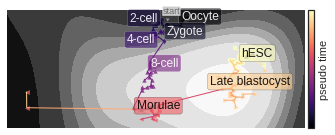

In [40]:
fig, ax = plt.subplots(figsize=(5,2))
mc.plot_waddington_landscape(ax=ax)
mc.plot_graph_nodes(labels, ulabels, start=start, ax=ax)
mc.plot_graph_labels(labels, ulabels, start=start, ax=ax, box=True)
mc.plot_time_graph_edges(start=start, ax=ax, startoffset=(-5,10))

mi, ma = Xgrid.min(0), Xgrid.max(0)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])

fig.tight_layout()
fig.savefig('../diagrams/Tang/Manifold_Tree_tang.pdf', transparent=True, bbox_inches='tight')

# Comparison to other methods first:

In [13]:
sns.set_style('white')

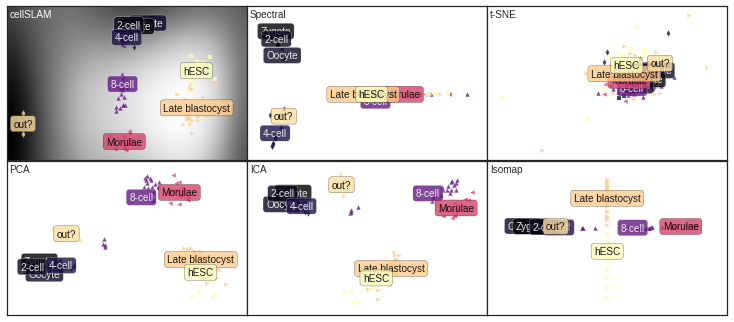

In [18]:
_l = labels.values.copy()
_l[[48, 53]] = 'out?'
_u = np.r_[ulabels, ['out?']]

fig, axes = plot_comparison(m, pseudo_time, X_init, dims, _l, _u)
#axes[0,0].legend(bbox_to_anchor=(0,1.02,3,.102), mode='expand', 
#                 ncol=len(ulabels), loc=3, borderaxespad=0,
#                 handletextpad=-.3,
#                 scatteryoffsets=[.5],)
fig.tight_layout(pad=0, w_pad=.01, h_pad=.03, rect=(0,0,1,1))
fig.savefig('../diagrams/Tang/method_comparison_with_outliers.pdf', transparent=True, bbox_inches='tight')

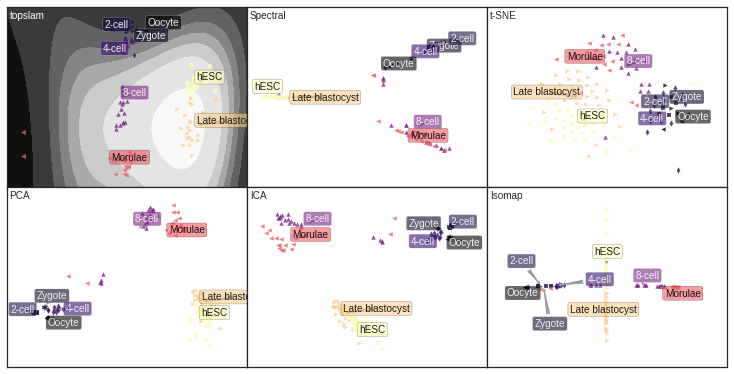

In [14]:
fig, axes = plot_comparison(mc, X_init, dims, labels.values, ulabels, start=start)

fig.tight_layout(pad=0, w_pad=.01, h_pad=.03, rect=(0,0,1,1))
fig.savefig('../diagrams/Tang/method_comparison_tang.pdf', transparent=True, bbox_inches='tight')

In [ ]:
_ = m.kern.plot_ARD()

# Cluster timeseries structure

In [7]:
expr = data.copy()
expr = expr.dropna(axis=1)
expr = np.log1p(expr)
expr -= expr.mean()
expr /= expr.std()
expr.index = expr.index.droplevel((1,2))
#expr.index = pd.MultiIndex.from_arrays([expr.index, pseudo_time], names=['cellstage', 'pseudotime'])

In [33]:
import GPclust

In [34]:
sort = pseudo_time.argsort()
mgp = GPclust.MOHGP(pseudo_time[sort,None], 
                    GPy.kern.Matern32(1, variance=1, lengthscale=30)+GPy.kern.Matern32(1, variance=1, lengthscale=1)+GPy.kern.WhiteHeteroscedastic(1, Y.shape[0], .2), 
                    GPy.kern.Matern32(1, variance=1, lengthscale=50)+GPy.kern.Matern32(1, variance=1, lengthscale=1)+GPy.kern.WhiteHeteroscedastic(1, Y.shape[0], .2), 
                    expr.values[sort].T.copy(), alpha=1)

In [36]:
mgp.hyperparam_opt_args['messages'] = False

In [37]:
mgp.optimize(verbose=True)

iteration 21 bound=-807314.885228 grad=9.8464534246e-07, beta=0.576786960812, step_length=1.0 vb converged (gtol)
iteration 46 bound=-500958.93433 grad=4.50267169032e-07, beta=0.396998468099, step_length=0.5 vb converged (ftol)
vb converged (gtol)
iteration 80 bound=-500231.711175 grad=9.88324633763e-07, beta=0.57419536145, step_length=0.25 vb converged (ftol)
vb converged (gtol)
iteration 127 bound=-500154.86759 grad=1.1292997816e-06, beta=0.660109749267, step_length=0.25 vb converged (ftol)
iteration 149 bound=-500147.926825 grad=5.56961201404e-07, beta=0.509181279575, step_length=0.25 vb converged (ftol)
vb converged (gtol)
iteration 170 bound=-500130.447046 grad=1.75369270649e-06, beta=0.540523916587, step_length=0.25 vb converged (ftol)
iteration 184 bound=-500127.168959 grad=1.56655104619e-06, beta=0.494629034732, step_length=0.25 vb converged (ftol)
iteration 221 bound=-500120.763717 grad=7.15022141175e-07, beta=0.496639291418, step_length=0.25 vb converged (ftol)
vb converged (

In [187]:
categories = pd.Categorical(labels)
nstages = len(categories.categories)
cols = categories.codes/float(nstages-1)

In [115]:
Xnew = np.linspace(pseudo_time.min(), pseudo_time.max(), 100)[:,None]

In [192]:
cmu, cvar = mgp.predict_components(Xnew)
nclusters = len(cmu)

In [450]:
pseudo_time_start_stop = pd.DataFrame(index=categories.categories, columns=['start', 'stop'])
for lab in ulabels:
    _fil = pseudo_time[labels==lab]
    pseudo_time_start_stop.loc[lab] = (_fil.min(), _fil.max())
bins = pd.to_numeric(pseudo_time_start_stop.start.sort_values(inplace=False)).values
Xnew_cellstage = np.digitize(Xnew, bins)/float(bins.size)

In [331]:
cluster_mean_vars = pd.concat([pd.DataFrame(np.c_[_c, np.diag(_v), Xnew_cellstage, Xnew], 
                                            columns=['mu', 'var', 'cell_stage', 'time']) for _c, _v in zip(cmu, cvar)], 
                              keys=range(nclusters))
cluster_mean_vars.index.names = ['cluster', 'index']
cluster_mean_vars = cluster_mean_vars.reset_index()

In [451]:
cluster_indices = mgp.phi.argmax(1)

In [452]:
cluster_sizes = pd.value_counts(cluster_indices)

In [48]:
cluster_genes = [expr.columns[cluster_indices==i] for i in range(mgp.phi.shape[1])]

In [61]:
mgp.pickle('Tang/gene_cluster_model.pickle')

In [80]:
df = pd.DataFrame(np.c_[cluster_indices, expr.columns], columns=['clusters','genes'])
df = df.set_index('clusters', append=True)
df = df.swaplevel(0,1)
df.sort_index(inplace=True)
df.index.names = ['clusters', 'gene_index']
df.to_csv('Tang/cluster_genes.csv')

In [92]:
mgp = GPy.load('Tang/gene_cluster_model.pickle')

In [8]:
clusters = pd.read_csv('Tang/cluster_genes.csv', index_col=[0,1])

In [10]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

load obo file go-basic.obo


go-basic.obo: format-version(1.2) data-version(releases/2016-05-07)


46564 nodes imported


In [11]:
from __future__ import print_function
from goatools.associations import read_ncbi_gene2go

geneid2gos_human = read_ncbi_gene2go("gene2go", taxids=[9606])

load obo file go-basic.obo


go-basic.obo: format-version(1.2) data-version(releases/2016-05-07)


46564 nodes imported


In [12]:
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GeneID2nt as GeneID2nt_homo

In [61]:
GOEnrichmentStudy?

In [13]:
from goatools.go_enrichment import GOEnrichmentStudy

In [62]:
symbol2id = dict(((GeneID2nt_homo[i].Symbol, i) for i in GeneID2nt_homo))

In [71]:
goeaobj = GOEnrichmentStudy(
        GeneID2nt_homo.keys(), # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

Propagating term counts to parents ..


18,273 out of 20,913 population items found in association


In [72]:
go_enrichment = {}
for cluster in clusters.index.levels[0]:
    study = goeaobj.run_study([symbol2id[symbol] for symbol in clusters.loc[cluster,'genes'] if symbol in symbol2id])
    go_enrichment[cluster] = [r for r in study if r.p_fdr_bh < 0.05]

Calculating uncorrected p-values using Fisher's exact test
   366 out of    370 study items found in association
Running multitest correction: statsmodels fdr_bh
20,426 GO terms are associated with 366 of 370 study items in a population of 20,913
Calculating uncorrected p-values using Fisher's exact test
   275 out of    279 study items found in association
Running multitest correction: statsmodels fdr_bh
20,426 GO terms are associated with 275 of 279 study items in a population of 20,913
Calculating uncorrected p-values using Fisher's exact test
    75 out of     75 study items found in association
Running multitest correction: statsmodels fdr_bh
20,426 GO terms are associated with 75 of 75 study items in a population of 20,913
Calculating uncorrected p-values using Fisher's exact test
   456 out of    461 study items found in association
Running multitest correction: statsmodels fdr_bh
20,426 GO terms are associated with 456 of 461 study items in a population of 20,913
Calculating un

In [303]:
enriched_go_terms = []
for c in go_enrichment:
    import collections as cx
    go_terms = go_enrichment[c]
    go_terms = sorted(go_terms, key=lambda x: x.p_fdr_bh)
    enriched_go_terms.append(pd.DataFrame([(r.GO, r.name, r.p_fdr_bh) for r in go_terms], columns=['GO', 'Name', 'BH p-value']))
enriched_go_terms = pd.concat(enriched_go_terms, keys=range(nclusters))

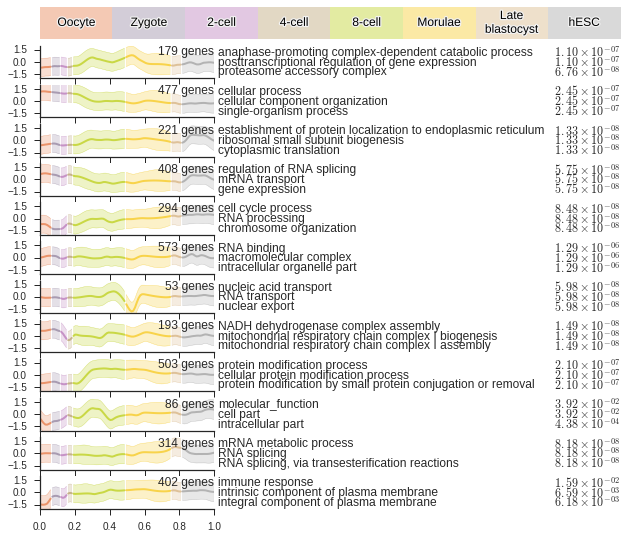

In [467]:
#rows, cols = GPy.plotting.gpy_plot.plot_util.find_best_layout_for_subplots(nclusters)
sns.set(style="ticks")#sns.set_style('white')
plt.rcParams['text.usetex'] = False
nenriched_clusters = np.unique(enriched_go_terms.index.get_level_values(0))
rows = len(nenriched_clusters)
cols = 1
fig = plt.figure(figsize=(10.4,9))
gs = plt.GridSpec(rows+1,10,wspace=0, hspace=.2)
cluster_index = nenriched_clusters.tolist()
upto = 3
cmap = plt.cm.Set2

for r in range(rows):
    rax = None
    for c in range(cols):
        try:
            _cl = cluster_index.pop()
            _tmp = cluster_mean_vars.set_index(['cluster', 'index']).loc[_cl]
            _clear = True
        except:
            break
        if rax is None:
            rax = ax = fig.add_subplot(gs[r+1,:upto])
            rax.set_ylim([-2,2])
            rax.set_yticks([-1.5, 0, 1.5])
        else:
            ax = fig.add_subplot(gs[r+1,:upto], sharey=rax)
        sns.despine(ax=ax)
        #ax.hlines(0,0,1,color='.7', linewidth=.5, linestyle='--', zorder=-1)
        #[tl.set_visible(False) for tl in ax.yaxis.get_ticklabels()]          
        if len(cluster_index):
            [tl.set_visible(False) for tl in ax.xaxis.get_ticklabels()]          
        for _, _c in _tmp.groupby('cell_stage'):
            _mu = _c.mu.values
            lower, upper = _mu-2*np.sqrt(_c['var'].values), _mu+2*np.sqrt(_c['var'].values)
            _col = cmap(_c.cell_stage.values[0])
            gpplot(_c.time.values, _mu, lower, upper, edgecol=_col, fillcol=_col, ax=ax)
        ax.text(1,1,str(cluster_sizes[_cl])+' genes',ha='right', va='top', transform=ax.transAxes, )
        
colpal = cmap(np.unique(Xnew_cellstage))
n = len(colpal)

ax = fig.add_subplot(gs[0, :])
ax.set_axis_off()

import matplotlib as mpl
ax.imshow(np.arange(n).reshape(1, n),
          cmap=mpl.colors.ListedColormap(list(colpal)),
          interpolation="nearest", aspect="auto", alpha=.5)
ax.set_xticks(np.arange(n) - .5)
#ax.set_xticks([-.5, .5])
ax.set_xticklabels([])
ax.set_yticklabels([])
import matplotlib.patheffects as path_effects
for i in range(len(ulabels)):
    _col = colpal[i]
    _col = 'k'
    text = ax.text(i,0,'\n'.join(ulabels[i].split(' ')), ha='center', va='center', color=_col, fontsize=12, rotation=0)
    text.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground='.95'),
                       path_effects.Normal()])


top3 = enriched_go_terms.xs(slice(0,2), axis=0, level=1, drop_level=False)
top3.loc[:,'BH p-value'] = top3.loc[:,'BH p-value'].apply(lambda x: '$'+('{:.2E}'.format(x)).replace('E', '\\times 10^{')+'}'+'$')

cluster_index = nenriched_clusters.tolist()
for _c in range(len(cluster_index)):
    ax = fig.add_subplot(gs[_c+1, upto:])
    ax.set_axis_off()
    _r = np.linspace(.2, .8, 3)
    for i in range(3):
        ax.text(.01,_r[i],top3.loc[cluster_index[_c]].loc[i, 'Name'], 
                ha='left', transform=ax.transAxes, va='center', fontsize=12)
        ax.text(1,_r[i],top3.loc[cluster_index[_c]].loc[i, 'BH p-value'], 
                ha='right', transform=ax.transAxes, va='center', fontsize=12, )
        

ax.figure.savefig('../diagrams/Tang/cluster_cellstage.pdf', transparent=True, bbox_inches='tight')


In [464]:
enriched_go_terms.loc[0]

GO                                               Name  \
0    GO:0022624                       proteasome accessory complex   
1    GO:0010608  posttranscriptional regulation of gene expression   
2    GO:0031145  anaphase-promoting complex-dependent catabolic...   
3    GO:0034660                            ncRNA metabolic process   
4    GO:0006396                                     RNA processing   
5    GO:0016070                              RNA metabolic process   
6    GO:0090304                     nucleic acid metabolic process   
7    GO:0006996                             organelle organization   
8    GO:1901360          organic cyclic compound metabolic process   
9    GO:0046483                      heterocycle metabolic process   
10   GO:0034641       cellular nitrogen compound metabolic process   
11   GO:0044237                         cellular metabolic process   
12   GO:0034470                                   ncRNA processing   
13   GO:0006725       cellular aromatic compound metabolic process   
14   GO:0008150                                 biological_process   
15   GO:1903047                         mitotic cell cycle process   
16   GO:0009987                                   cellular process   
17   GO:0006139   nucleobase-containing compound metabolic process   
18   GO:0044260           cellular macromolecule metabolic process   
19   GO:0044429                                 mitochondrial part   
20   GO:0005743                       mitochondrial inner membrane   
21   GO:0005730                                          nucleolus   
22   GO:0030529            intracellular ribonucleoprotein complex   
23   GO:1990904                          ribonucleoprotein complex   
24   GO:0005654                                        nucleoplasm   
25   GO:0043228                     non-membrane-bounded organelle   
26   GO:0043232       intracellular non-membrane-bounded organelle   
27   GO:0044428                                       nuclear part   
28   GO:0043234                                    protein complex   
29   GO:0030684                                        preribosome   
..          ...                                                ...   
433  GO:0003697                        single-stranded DNA binding   
434  GO:0090501                 RNA phosphodiester bond hydrolysis   
435  GO:0098803                          respiratory chain complex   
436  GO:0000289   nuclear-transcribed mRNA poly(A) tail shortening   
437  GO:0000466  maturation of 5.8S rRNA from tricistronic rRNA...   
438  GO:1904116                            response to vasopressin   
439  GO:1904117                   cellular response to vasopressin   
440  GO:0000451                              rRNA 2'-O-methylation   
441  GO:0000453              enzyme-directed rRNA 2'-O-methylation   
442  GO:0044205                 'de novo' UMP biosynthetic process   
443  GO:0005790                       smooth endoplasmic reticulum   
444  GO:0005826                        actomyosin contractile ring   
445  GO:0043564                                  Ku70:Ku80 complex   
446  GO:0016436          rRNA (uridine) methyltransferase activity   
447  GO:0051169                                  nuclear transport   
448  GO:0044437                                      vacuolar part   
449  GO:0006413                           translational initiation   
450  GO:0006094                                    gluconeogenesis   
451  GO:0061718              glucose catabolic process to pyruvate   
452  GO:0061621                               canonical glycolysis   
453  GO:0006735                                  NADH regeneration   
454  GO:0005761                             mitochondrial ribosome   
455  GO:0000313                                organellar ribosome   
456  GO:0016866                intramolecular transferase activity   
457  GO:0050907  detection of chemical stimulus involved in sen...   
458  GO:0048519        

In [90]:
pd.concat(enriched_go_terms, keys=go_enrichment.keys()).to_csv('Tang/cluster_go_term_association.csv')

In [69]:
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

In [70]:
plot_results("Tang/cluster_go_0_{NS}.svg", go_enrichment.values()[0])

  WROTE: Tang/cluster_go_0_CC.svg
  WROTE: Tang/cluster_go_0_MF.svg
  WROTE: Tang/cluster_go_0_BP.svg


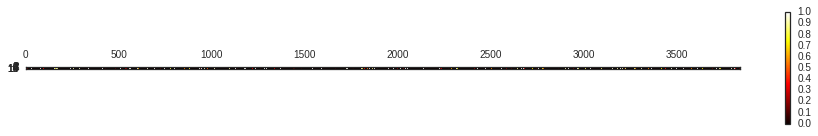

In [41]:
plt.matshow(mgp.phi.T, cmap='hot', )
plt.colorbar()

In [ ]:
sns.set_style('white')
fig = plt.figure(figsize=(6,3))
mgp.plot(colour=True, newfig=False, )
plt.tight_layout()
#plt.setp(fig.axes[-4:], xticks=[0,40,80,120])
sns.utils.despine(fig)
plt.savefig('../diagrams/Tang/timeseries_clusters.pdf', transparent=True, bbox='tight')